In [14]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from sklearn.model_selection import TimeSeriesSplit

from sklearn.preprocessing import OneHotEncoder

import datetime as dt

In [15]:
df = pd.read_csv('data/Microsoft_Stock.csv', parse_dates=['Date'])

time_data = df[['Date', 'Close']]

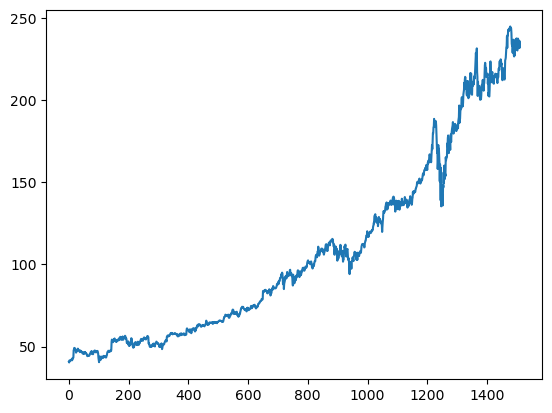

In [16]:
plt.plot(df.index, df['Close'])

In [17]:
def window_data(data, n=3):
    windowed_data = pd.DataFrame()
    for i in range(n, 0, -1):
        windowed_data[f'Target-{i}'] = data['Close'].shift(i)
    windowed_data['Target'] = data['Close']
    return windowed_data.dropna()

In [18]:
windowed_df = pd.merge(time_data['Date'], window_data(time_data), left_index=True, right_index=True)

In [19]:
windowed_df.head(10)

,Date,Target-3,Target-2,Target-1,Target
3,2015-04-07 16:00:00,40.72,40.29,41.55,41.53
4,2015-04-08 16:00:00,40.29,41.55,41.53,41.42
5,2015-04-09 16:00:00,41.55,41.53,41.42,41.48
6,2015-04-10 16:00:00,41.53,41.42,41.48,41.72
7,2015-04-13 16:00:00,41.42,41.48,41.72,41.76
8,2015-04-14 16:00:00,41.48,41.72,41.76,41.65
9,2015-04-15 16:00:00,41.72,41.76,41.65,42.26
10,2015-04-16 16:00:00,41.76,41.65,42.26,42.16
11,2015-04-17 16:00:00,41.65,42.26,42.16,41.62
12,2015-04-20 16:00:00,42.26,42.16,41.62,42.91


In [20]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((1508,), (1508, 3, 1), (1508,))

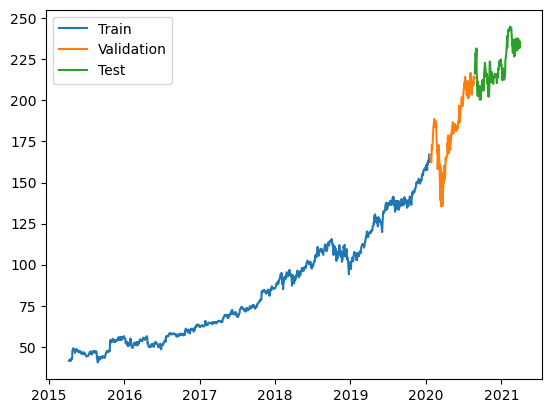

In [21]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [22]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) 
model.fit(X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        callbacks=[early_stopping],
        #verbose=100
        )

Epoch 1/100
38/38 [==============================] - 11s 60ms/step - loss: 7843.9038 - mean_absolute_error: 82.3971 - val_loss: 32640.3906 - val_mean_absolute_error: 179.5273
Epoch 2/100
38/38 [==============================] - 0s 10ms/step - loss: 6272.7725 - mean_absolute_error: 71.3651 - val_loss: 24957.4141 - val_mean_absolute_error: 156.5650
Epoch 3/100
38/38 [==============================] - 0s 10ms/step - loss: 1848.1948 - mean_absolute_error: 33.2196 - val_loss: 9744.7852 - val_mean_absolute_error: 96.6126
Epoch 4/100
38/38 [==============================] - 0s 11ms/step - loss: 1014.2753 - mean_absolute_error: 27.7682 - val_loss: 9886.3350 - val_mean_absolute_error: 97.3618
Epoch 5/100
38/38 [==============================] - 1s 14ms/step - loss: 406.3790 - mean_absolute_error: 13.1408 - val_loss: 4531.3042 - val_mean_absolute_error: 64.2370
Epoch 6/100
38/38 [==============================] - 0s 10ms/step - loss: 41.8512 - mean_absolute_error: 2.8766 - val_loss: 2369.0869 - 

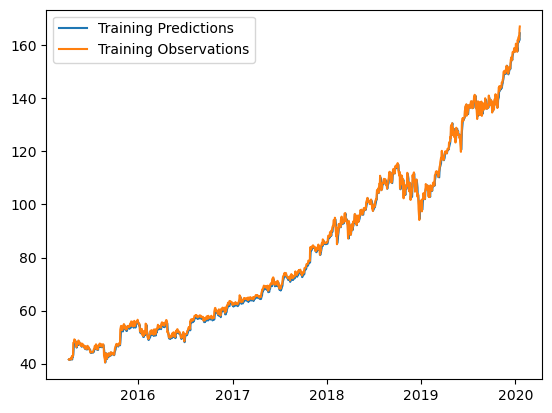

In [23]:
train_predictions = model.predict(X_train, verbose=False).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

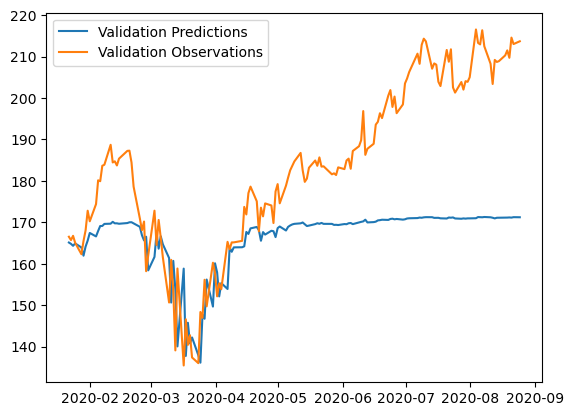

In [24]:
val_predictions = model.predict(X_val, verbose=False).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

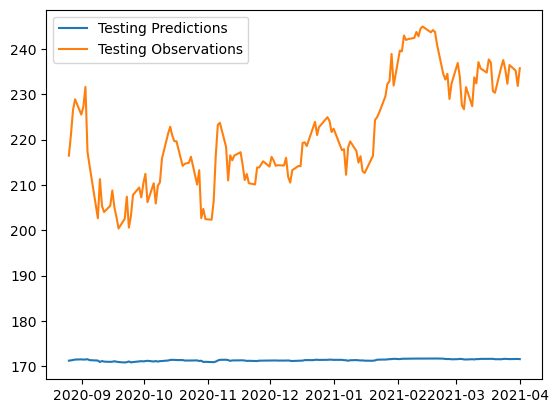

In [25]:
test_predictions = model.predict(X_test, verbose=False).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

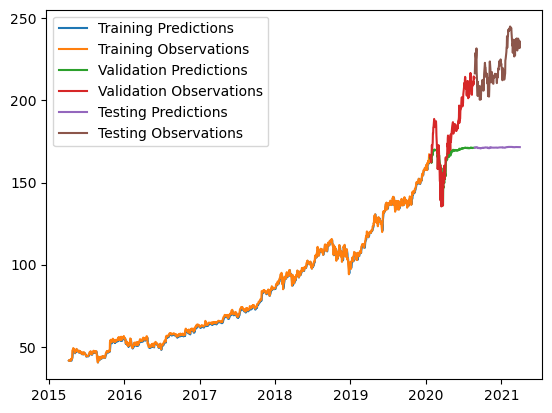

In [26]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])